# Выпускной проект "Идентификация интернет-пользователей" Week 2

> Graduation project "Identification of Internet users" Week 2

- toc: true
- branch: master
- badges: true
- comments: true
- author: Zmey56
- categories: [graduation project, machine learning, stepik, yandex]

**Неделя 2.** Подготовка и первичный анализ данных

На второй неделе мы продолжим подготавливать данные для дальнейшего анализа и построения прогнозных моделей. Конкретно, раньше мы определили что сессия – это последовательность из 10 посещенных пользователем сайтов, теперь сделаем длину сессии параметром, и потом при обучении прогнозных моделей выберем лучшую длину сессии. Также мы познакомимся с предобработанными данными и статистически проверим первые гипотезы, связанные с нашими наблюдениями.

План 2 недели:

* Подготовка нескольких обучающих выборок для сравнения
* Первичный анализ данных, проверка гипотез


### Подготовка нескольких обучающих выборок для сравнения

Пока мы брали последовательности из 10 сайтов, и это было наобум. Давайте сделаем число сайтов в сессии параметром, чтоб в дальнейшем сравнить модели классификации, обученные на разных выборках – с 5, 7, 10 и 15 сайтами в сессии. Более того, пока мы брали по 10 сайтов подряд, без пересечения. Теперь давайте применим идею скользящего окна – сессии будут перекрываться. 

**Пример**: для длины сессии 10 и ширины окна 7 файл из 30 записей породит не 3 сессии, как раньше (1-10, 11-20, 21-30), а 5 (1-10, 8-17, 15-24, 22-30, 29-30). При этом в предпоследней сессии будет один ноль, а в последней – 8 нолей.

Создадим несколько выборок для разных сочетаний параметров длины сессии и ширины окна. Все они представлены в табличке ниже:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e">session_length -&gt;<br>window_size <br></th>
    <th class="tg-031e">5</th>
    <th class="tg-031e">7</th>
    <th class="tg-031e">10</th>
    <th class="tg-031e">15</th>
  </tr>
  <tr>
    <td class="tg-031e">5</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
  <tr>
    <td class="tg-031e">7</td>
    <td class="tg-031e"></td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
  <tr>
    <td class="tg-031e">10</td>
    <td class="tg-031e"></td>
    <td class="tg-031e"></td>
    <td class="tg-031e"><font color='green'>v</font></td>
    <td class="tg-031e">v</td>
  </tr>
</table>

Итого должно получиться 18 разреженных матриц – указанные в таблице 9 сочетаний параметров формирования сессий для выборок из 10 и 150 пользователей. При этом 2 выборки мы уже сделали в прошлой части, они соответствуют сочетанию параметров: session_length=10, window_size=10, которые помечены в таблице выше галочкой зеленого цвета (done).

Реализуйте функцию prepare_sparse_train_set_window.

Аргументы:

* path_to_csv_files – путь к каталогу с csv-файлами
* site_freq_path – путь к pickle-файлу с частотным словарем, полученным в 1 части проекта
* session_length – длина сессии (параметр)
* window_size – ширина окна (параметр)

Функция должна возвращать 2 объекта:

* разреженную матрицу X_sparse (двухмерная Scipy.sparse.csr_matrix), в которой строки соответствуют сессиям из session_length сайтов, а max(site_id) столбцов – количеству посещений site_id в сессии.
* вектор y (Numpy array) "ответов" в виде ID пользователей, которым принадлежат сессии из X_sparse

Детали:

* Модифицируйте созданную в 1 части функцию prepare_train_set
* Некоторые сессии могут повторяться – оставьте как есть, не удаляйте дубликаты
* Замеряйте время выполнения итераций цикла с помощью time из time, tqdm из tqdm или с помощью виджета log_progress (статья о нем на Хабрахабре)
* 150 файлов из capstone_websites_data/150users/ должны обрабатываться за несколько секунд (в зависимости от входных параметров). Если дольше – не страшно, но знайте, что функцию можно ускорить.



In [ ]:
import os
import time
import pickle
import math
import pylab 
import collections

import pandas as pd
import numpy as np
import scipy.sparse as sps
import scipy.stats as stats
import matplotlib.pyplot as plt

from glob import glob
from tqdm.auto import tqdm
from scipy.sparse import csr_matrix
from datetime import timedelta
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Подготовка нескольких обучающих выборок для сравнения

In [ ]:
PATH_TO_DATA = '/content/drive/MyDrive/DATA/Stepik/capstone_user_identification'

In [ ]:
def prepare_sparse_train_set_window(path_to_csv_files, site_freq_path, session_length=10, window_size=10):
    
    stock_files = sorted(glob(path_to_csv_files))
    
    #создать общий датафрейм со всеми пользователями и сайтами
    df = pd.concat((pd.read_csv(file) for file in stock_files), ignore_index=True)

    #прочесть файл с именем сайта, идентификационным номером и частотой
    with open(site_freq_path, "rb") as fp:
      df_site_dict = pickle.load(fp)
    
    #create number list site
    list_all_site = []
    user_list = []
    #user = 1
    for filename in stock_files:
        tmp_df = pd.read_csv(filename)
        #print(filename[-12:-4])
        user = filename[-12:-4]
        list_site = []
        #прочитать отдельно по каждому юзеру сессии и преобразовать сайты в их идентификаторы
        for site in tmp_df.site:
            list_site.append(df_site_dict.get(site)[0])
        count = 0
        #перебор начала окна в зависимости от его ширины
        for start in range(0, (len(list_site) + window_size), window_size):
            ind_1 = start
            ind_2 = start + session_length #параметр для условия
            if ind_2 <= (len(list_site)-1):
                sess = list_site[ind_1 : ind_2]
                list_all_site.append(sess)
                user_list.append(user)
            elif(len(list_site[ind_1:]) !=0):
                sess = list_site[ind_1:] + [0 for _ in range(session_length - len(list_site[ind_1:]))]
                list_all_site.append(sess)
                user_list.append(user)
        #user = user + 1
    
    #теперь разряженная матрица
    X_toy = pd.DataFrame(list_all_site).values
    X_sparse_toy = csr_matrix((np.ones(X_toy.size, dtype=int), X_toy.reshape(-1), \
                           np.arange(X_toy.shape[0] + 1) * X_toy.shape[1]))[:, 1:]
    
    return(X_sparse_toy, np.array(user_list))

Применю полученную функцию с параметрами *session_length=5* и *window_size=3* к игрушечному примеру. Убедитесь, что все работает как надо.

In [ ]:
start = time.time()

X_toy_s5_w3, y_s5_w3 = prepare_sparse_train_set_window(os.path.join(PATH_TO_DATA, '3users/*.csv'), os.path.join(PATH_TO_DATA, 'site_freq_3users.pkl'), session_length=5, window_size=3)

end = time.time()

print(timedelta(seconds=end-start))

0:00:00.022730


In [ ]:
X_toy_s5_w3.todense()

matrix([[0, 3, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0],
        [3, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
y_s5_w3

array(['user0001', 'user0001', 'user0001', 'user0001', 'user0001',
       'user0002', 'user0002', 'user0003', 'user0003', 'user0003',
       'user0003', 'user0003'], dtype='<U8')

**Все совпало с представленным примером**

---

Запущу созданную функцию 16 раз с помощью циклов по числу пользователей num_users (10 или 150), значениям параметра *session_length* (15, 10, 7 или 5) и значениям параметра *window_size* (10, 7 или 5). Сериализуйте все 16 разреженных матриц (обучающие выборки) и векторов (метки целевого класса – ID пользователя) в файлы `X_sparse_{num_users}users_s{session_length}_w{window_size}.pkl` и `y_{num_users}users_s{session_length}_w{window_size}.pkl`.

Чтоб убедиться, что мы все далее будем работать с идентичными объектами, запишите в список *data_lengths* число строк во всех полученных рареженных матрицах (16 значений). Если какие-то будут совпадать, это нормально (можно сообразить, почему).

На моем ноутбуке этот участок кода отработал за 26 секунд, хотя понятно, что все зависит от эффективности реализации функции *prepare_sparse_train_set_window* и мощности используемого железа. И честно говоря, моя первая реализация была намного менее эффективной (34 минуты), так что тут у Вас есть возможность оптимизировать свой код.

In [ ]:
#%%time
import itertools

start = time.time()

data_lengths = []
user_tmp=[]

for num_users in [10, 150]:
    for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
        if (window_size <= session_length) and ((window_size, session_length) != (10, 10)):
            if num_users == 10:
                path = os.path.join(PATH_TO_DATA, '10users/*.csv')
                unpickled_df = os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl')
            else:
                path = os.path.join(PATH_TO_DATA, '150users/*.csv')
                unpickled_df = os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl')   
            print("NUM USER = ", num_users, " Window Size = ", window_size, " Session Length = ", session_length)
            end = time.time()
            print(timedelta(seconds=end-start))
            #print(unpickled_df)
            X_sparse, y = prepare_sparse_train_set_window(path, unpickled_df, session_length, window_size)
            data_lengths.append(X_sparse.shape[0])
            user_tmp.append(len(y))
            #print(len(y))
            
            file_name = os.path.join(PATH_TO_DATA, 'sparse/X_sparse_%dusers_s%d_w%d.pkl' % (num_users, session_length, window_size))
            with open(file_name, 'wb') as fp:
                pickle.dump(X_sparse, fp)
            file_name = os.path.join(PATH_TO_DATA,'sparse/y_%dusers_s%d_w%d.pkl' % (num_users, session_length, window_size))
            with open(file_name,'wb') as fp:
                pickle.dump(y, fp)
                
            data_lengths.append(X_sparse.shape[0])
            
            #print(data_lengths)

end = time.time()

print(timedelta(seconds=end-start))

NUM USER =  10  Window Size =  10  Session Length =  15
0:00:00.003979
NUM USER =  10  Window Size =  7  Session Length =  15
0:00:00.457232
NUM USER =  10  Window Size =  7  Session Length =  10
0:00:01.009698
NUM USER =  10  Window Size =  7  Session Length =  7
0:00:01.452218
NUM USER =  10  Window Size =  5  Session Length =  15
0:00:01.917664
NUM USER =  10  Window Size =  5  Session Length =  10
0:00:02.484663
NUM USER =  10  Window Size =  5  Session Length =  7
0:00:02.953907
NUM USER =  10  Window Size =  5  Session Length =  5
0:00:03.404516
NUM USER =  150  Window Size =  10  Session Length =  15
0:00:03.863693
NUM USER =  150  Window Size =  7  Session Length =  15
0:00:08.548853
NUM USER =  150  Window Size =  7  Session Length =  10
0:00:13.495581
NUM USER =  150  Window Size =  7  Session Length =  7
0:00:18.213572
NUM USER =  150  Window Size =  5  Session Length =  15
0:00:22.648985
NUM USER =  150  Window Size =  5  Session Length =  10
0:00:28.012223
NUM USER =  150 

Важно отметить, что после того, как я отключил tqdm, то время обработки с 1,5 часа упало до 51 секунды.

Запишите в файл *answer2_1.txt* все числа из списка *data_lengths* через пробел. Полученный файл будет ответом на 1 вопрос теста.

In [ ]:
def write_answer_to_file(answer, file_address):
    with open(file_address, 'w') as out_f:
        out_f.write(str(answer))

In [ ]:
write_answer_to_file(' '.join([str(elem) for elem in data_lengths]), 'answer2_1.txt')

*Важно отметить, что на Stepik не принимался ответ через пробел. И пробелы пришлось убрать.*

## Первичный анализ данных, проверка гипотез

Считаю в DataFrame подготовленный на 1 неделе файл train_data_10users.csv. Далее буду работать с ним.

In [ ]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_10users.csv'), 
                       index_col='session_id')

In [ ]:
train_df.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
session_id,,,,,,,,,,,
0,192,574,133,3,133,133,3,133,203,133,user0031
1,415,193,674,254,133,31,393,3305,217,55,user0031
2,55,3,55,55,5,293,415,333,897,55,user0031
3,473,3306,473,55,55,55,55,937,199,123,user0031
4,342,55,5,3307,258,211,3308,2086,675,2086,user0031


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14061 entries, 0 to 14060
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   site1    14061 non-null  int64 
 1   site2    14061 non-null  int64 
 2   site3    14061 non-null  int64 
 3   site4    14061 non-null  int64 
 4   site5    14061 non-null  int64 
 5   site6    14061 non-null  int64 
 6   site7    14061 non-null  int64 
 7   site8    14061 non-null  int64 
 8   site9    14061 non-null  int64 
 9   site10   14061 non-null  int64 
 10  user_id  14061 non-null  object
dtypes: int64(10), object(1)
memory usage: 1.3+ MB


Распределение целевого класса:

In [ ]:
train_df['user_id'].value_counts()

user0128    2796
user0039    2204
user0207    1868
user0127    1712
user0237    1643
user0033    1022
user0050     802
user0031     760
user0100     720
user0241     534
Name: user_id, dtype: int64

Посчитаем распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов.

In [ ]:
num_unique_sites = [np.unique(train_df.values[i, :-1]).shape[0] 
                    for i in range(train_df.shape[0])]

In [ ]:
pd.Series(num_unique_sites).value_counts()

7     2308
6     2197
8     2046
5     1735
9     1394
2     1246
4     1163
3      894
10     651
1      427
dtype: int64

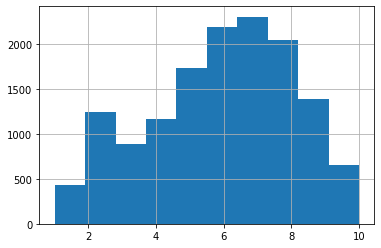

In [ ]:
pd.Series(num_unique_sites).hist();

Проверю с помощью QQ-плота и критерия Шапиро-Уилка, что эта величина распределена нормально и сделаю вывод. Ответом на второй вопрос в тесте будет файл со словом "YES" или "NO" в зависимости от того, распределено ли нормально число уникальных сайтов в сессии.

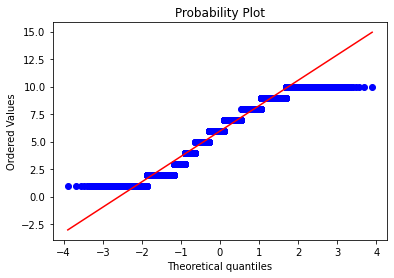

In [ ]:
stats.probplot(num_unique_sites, dist="norm", plot=pylab)
pylab.show()

In [ ]:
stat, p = stats.shapiro(num_unique_sites)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.955, p=0.000
Sample does not look Gaussian (reject H0)


**Распределение не является нормальным**

Проверю гипотезу о том, что пользователь хотя бы раз зайдет на сайт, который он уже ранее посетил в сессии из 10 сайтов. Проверю с помощью биномиального критерия для доли, что доля случаев, когда пользователь повторно посетил какой-то сайт (то есть число уникальных сайтов в сессии < 10) велика: больше 95% (необходимо обратите внимание, что альтернатива тому, что доля равна 95% – одностороняя). Ответом на 3 вопрос в тесте будет полученное p-value.

In [ ]:
has_two_similar = (np.array(num_unique_sites) < 10).astype('int')

In [ ]:
len(num_unique_sites)

14061

In [ ]:
stats.binom_test(has_two_similar.sum(), has_two_similar.shape[0], 0.95, alternative='greater')

0.02207653769072678

**p-value значение 0,022**

Построю для этой доли 95% доверительный интервал Уилсона. Округлю границу интервала до 3 знаков после запятой. 

In [ ]:
wilson_interval = proportion_confint(has_two_similar.sum(), has_two_similar.shape[0], method='wilson')
wilson_interval

(0.9501028841411286, 0.9570527377232229)

**Интервалы 0,950 и 0,957**

Каков 95%-доверительный интервал для средней частоты появления сайта в выборке? Необходимо построить 95% доверительный интервал для средней частоты появления сайта в выборке (во всей, уже не только для тех сайтов, что были посещены как минимум 1000 раз) на основе bootstrap. Используйте столько же bootstrap-подвыборок, сколько сайтов оказалось в исходной выборке по 10 пользователям. Буду брать подвыборки из посчитанного списка частот посещений сайтов – не надо заново считать эти частоты. Необходимо учесть, что частоту появления нуля (сайт с индексом 0 появлялся там, где сессии были короче 10 сайтов) включать не надо. Округлите границы интервала до 3 знаков после запятой.

> Bagging (от Bootstrap aggregation) — это один из первых и самых простых видов ансамблей. Он был придуман Ле́о Бре́йманом в 1994 году. Бэггинг основан на статистическом методе бутстрэпа, который позволяет оценивать многие статистики сложных распределений.


> Метод бутстрэпа заключается в следующем. Пусть имеется выборка $\large X$ размера $\large N$. Равномерно возьмем из выборки $\large N$ объектов с возвращением. Это означает, что мы будем $\large N$ раз выбирать произвольный объект выборки (считаем, что каждый объект «достается» с одинаковой вероятностью $\large \frac{1}{N}$), причем каждый раз мы выбираем из всех исходных $\large N$ объектов. Можно представить себе мешок, из которого достают шарики: выбранный на каком-то шаге шарик возвращается обратно в мешок, и следующий выбор опять делается равновероятно из того же числа шариков. Отметим, что из-за возвращения среди них окажутся повторы. Обозначим новую выборку через $\large X_1$. Повторяя процедуру $\large M$ раз, сгенерируем $\large M$ подвыборок $\large X_1, \dots, X_M$. Теперь мы имеем достаточно большое число выборок и можем оценивать различные статистики исходного распределения.[link](https://habr.com/ru/company/ods/blog/324402/#1-begging)

In [ ]:
def get_bootstrap_samples(data, n_samples, random_seed=56):
    # функция для генерации подвыборок с помощью бутстрэпа
    np.random.seed(random_seed)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [ ]:
def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, 
                 [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [ ]:
stock_files = sorted(glob(os.path.join(PATH_TO_DATA, '10users/*.csv')))
df = pd.concat((pd.read_csv(file) for file in stock_files), ignore_index=True)

In [ ]:
df.head()

,timestamp,site
0,2013-11-15 08:12:07,fpdownload2.macromedia.com
1,2013-11-15 08:12:17,laposte.net
2,2013-11-15 08:12:17,www.laposte.net
3,2013-11-15 08:12:17,www.google.com
4,2013-11-15 08:12:18,www.laposte.net


In [ ]:
sorted_site = dict(collections.OrderedDict(sorted(Counter(df.site).items(), key=lambda kv: kv[1], reverse = True)))

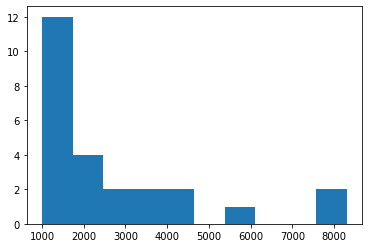

In [ ]:
sorted_site_1000 = {}

for key, value in sorted_site.items():
    if value >= 1000:
        sorted_site_1000[key] = value
    
plt.hist(list(sorted_site_1000.values()))
plt.show()

In [ ]:
site_freq = list(sorted_site.values())

In [ ]:
site_mean_scores = list(map(np.mean, get_bootstrap_samples(np.array(site_freq), len(site_freq))))

In [ ]:
print ("95% confidence interval for the ILEC median repair time:",  stat_intervals(site_mean_scores, 0.05))

95% confidence interval for the ILEC median repair time: [22.53311622 36.08414411]


**В итоге мы получили, что с 95% вероятностью средняя частота сайтов лежит в промежутке между 22,515 и 35,763**